In [123]:
import spacy
import pytextrank
import gspread
import pandas as pd
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random
from wordcloud import WordCloud
import operator

import pyLDAvis.gensim_models

# Visualise inside a notebook
pyLDAvis.enable_notebook()
from collections import Counter
import os
import re
from typing import List, Tuple, Dict
import numpy as np

In [46]:
# list all .txt files from a directory data/boox_exports
list_boox_exports = os.listdir('data/boox_exports')

In [47]:
def parse_book_notes(text: str) -> List[Dict[str, str]]:
    notes = []

    # Split the text by '-------------------' separator
    sections = re.split(r'-{3,}', text)

    # Iterate through each section
    for section in sections:
        # Create a dictionary for each note
        note = {}
            
        # Extract time
        time_match = re.search(r"Time：(.+)", section)
        if time_match:
            note["time"] = time_match.group(1).strip()
            
        # Extract original text
        original_text_match = re.search(r"【Original Text】(.+)", section, re.DOTALL)
        if original_text_match:
            note["original_text"] = original_text_match.group(1).strip()
            if '【Annotations】' in note["original_text"]:
                note["original_text"] = note["original_text"].split('【Annotations】')[0]
            # remove newlines
            note["original_text"] = note["original_text"].replace('\n', '')
            
        # Extract annotations
        annotations_match = re.search(r"【Annotations】(.+)", section, re.DOTALL)
        if annotations_match:
            note["annotations"] = annotations_match.group(1).strip()
            
        # Extract page number
        page_number_match = re.search(r"【Page Number】(.+)", section)
        if page_number_match:
            note["page_number"] = page_number_match.group(1).strip()
            
        # If the note dictionary is not empty, append it to the notes list
        if note:
            notes.append(note)

    return notes


In [86]:
notes_list = []
for book_notes in list_boox_exports:
    # read the file
    with open(f'data/boox_exports/{book_notes}', 'r') as f:
        text = f.read()
        notes = parse_book_notes(text)
        notes_list.extend(notes)
        print(f'Loaded {len(notes)} notes from {book_notes}')

Loaded 26 notes from Rumelt, Richard - Good Strategy_Bad Strategy-annotation-2023-04-01_09_11_16.txt
Loaded 4 notes from Dare to Lead Brave Work. Tough Conversations. Whole Hearts-annotation-2023-04-01_10_07_23.txt
Loaded 14 notes from Keith Ferrazzi, Tahl Raz - Never Eat Alone-annotation-2023-04-01_10_08_14.txt
Loaded 24 notes from How the World Really Works (Vaclav Smil)-annotation-2023-04-01_10_08_47.txt


In [87]:
len(notes_list)

68

In [88]:
notes_list

[{'time': '2023-03-18 18:49',
  'original_text': 'A leader’s most important responsibility is identifying the biggest challenges to forward progress and devising a coherent approach to overcoming them.',
  'annotations': '【Page Number】17',
  'page_number': '17'},
 {'time': '2023-03-18 19:00',
  'original_text': 'The kernel of a strategy contains three elements: a diagnosis, a guiding policy, and coherent action',
  'annotations': '【Page Number】22',
  'page_number': '22'},
 {'time': '2023-03-19 08:07',
  'original_text': 'The second natural advantage of many good strategies comes from insight into new sources of strength and weakness',
  'annotations': '【Page Number】37',
  'page_number': '37'},
 {'time': '2023-03-19 08:10',
  'original_text': 'The story teaches us that our preconceived ideas of strength and weakness may be unsound',
  'annotations': '【Page Number】38',
  'page_number': '38'},
 {'time': '2023-03-19 08:40',
  'original_text': 'Bad strategy is long on goals and short on pol

In [50]:
# create dataframe from csv
df_readwise = pd.read_csv('data/readwise/readwise-data.csv')

In [52]:
df_readwise.head()

,Highlight,Book Title,Book Author,Amazon Book ID,Note,Color,Tags,Location Type,Location,Highlighted at,Document tags
0,The ultimate form of intrinsic motivation is when a habit becomes part of your identity. It’s one thing to say I’m the type of person who wants this. It’s something very different to say I’m the type of person who is this.,Atomic Habits: An Easy and Proven Way to Build Good Habits and Break Bad Ones,James Clear,B01N5AX61W,NaN,yellow,NaN,location,497,2020-05-06 04:56:00+00:00,NaN
1,"We do not change by snapping our fingers and deciding to be someone entirely new. We change bit by bit, day by day, habit by habit.6 We are continually undergoing microevolutions of the self.",Atomic Habits: An Easy and Proven Way to Build Good Habits and Break Bad Ones,James Clear,B01N5AX61W,NaN,yellow,NaN,location,562,2020-05-06 04:56:00+00:00,NaN
2,It is a simple two-step process: Decide the type of person you want to be. Prove it to yourself with small wins.,Atomic Habits: An Easy and Proven Way to Build Good Habits and Break Bad Ones,James Clear,B01N5AX61W,NaN,yellow,NaN,location,583,2020-05-06 04:56:00+00:00,NaN
3,"As the psychologist Carl Jung said, “Until you make the unconscious conscious, it will direct your life and you will call it fate.”9",Atomic Habits: An Easy and Proven Way to Build Good Habits and Break Bad Ones,James Clear,B01N5AX61W,NaN,yellow,NaN,location,845,2020-05-06 04:56:00+00:00,NaN
4,Every habit is context dependent.,Atomic Habits: An Easy and Proven Way to Build Good Habits and Break Bad Ones,James Clear,B01N5AX61W,NaN,yellow,NaN,location,1125,2020-05-06 04:56:00+00:00,NaN


In [89]:
highlights = df_readwise['Highlight'].tolist()
highlights_boox = list(map(lambda x: x['original_text'], notes_list))

In [91]:
highlights_merged = highlights + highlights_boox
# create dataframe from list
df_highlights = pd.DataFrame(highlights_merged, columns=['Highlights'])

In [93]:

nlp = en_core_web_md.load()

# Tags I want to remove from the text
removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT',
           'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']

tokens = []
for highlight in nlp.pipe(df_highlights['Highlights']):
   proj_tok = [token.lemma_.lower(
   ) for token in highlight if token.pos_ not in removal and not token.is_stop and token.is_alpha and len(token) > 2]
   # filter manually - remove all tokens that are in the list tokens_to_remove
   tokens.append(proj_tok)

tokens_concatenated = list(map(lambda x: ' '.join(x), tokens))
tokens_cleaned = list(map(lambda x: get_cleaned_string(x), tokens_concatenated))

dictionary = Dictionary(tokens)

dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

corpus = [dictionary.doc2bow(doc) for doc in tokens]


In [94]:
tokens_count = dict(Counter(sum(tokens, [])))
tokens_count = dict(
    sorted(tokens_count.items(), key=operator.itemgetter(1), reverse=True))


In [95]:
tokens_count_df = pd.DataFrame(tokens_count.items(), columns=['token', 'occurences_count']).sort_values('occurences_count', ascending=False)

In [96]:
tokens_count_df.head()

,token,occurences_count
0,sleep,69
1,people,56
2,good,48
3,time,37
4,new,35


In [97]:
len(tokens_count)

2668

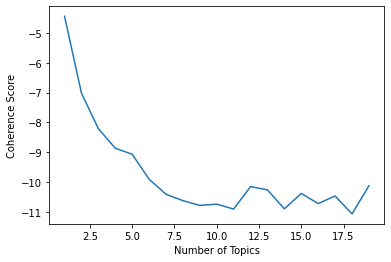

In [98]:

lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


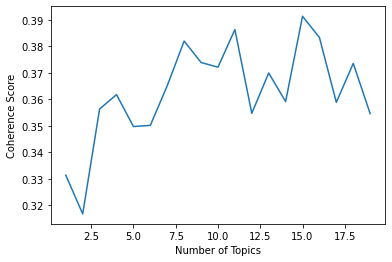

In [99]:

# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = tokens, corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


In [114]:

# Optimal model
topics_count = 15
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=topics_count, workers = 4, passes=100)

# Print topics
lda_model.print_topics(-1)

# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, R=10)
pyLDAvis.display(lda_display)

# Save the report
pyLDAvis.save_html(lda_display, f'data/generated_html/index_{topics_count}.html')


/home/niko/anaconda3/envs/py39/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/home/niko/anaconda3/envs/py39/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/niko/anaconda3/envs/py39/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/niko/anaconda3/envs/py39/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/niko/anaconda3/envs

In [115]:
data = list(map(lambda x: x[1], lda_model.print_topics(-1)))

In [116]:
def extract_words(text):
    words = re.findall(r'"(.*?)"', text)
    return words

word_lists = [extract_words(item) for item in data]

In [117]:
print(word_lists)

[['sleep', 'rem', 'hour', 'brain', 'night', 'percent', 'lose', 'morning', 'time', 'deep'], ['new', 'network', 'link', 'idea', 'time', 'practice', 'assign', 'level', 'take', 'group'], ['know', 'life', 'thing', 'love', 'people', 'learn', 'way', 'change', 'deal', 'single'], ['time', 'change', 'end', 'percent', 'mean', 'build', 'experience', 'world', 'habit', 'seek'], ['strategy', 'help', 'individual', 'life', 'goal', 'word', 'world', 'job', 'real', 'example'], ['good', 'knowledge', 'human', 'strategy', 'work', 'future', 'find', 'new', 'pattern', 'value'], ['action', 'resource', 'story', 'policy', 'great', 'life', 'high', 'good', 'give', 'ability'], ['understand', 'say', 'percent', 'world', 'mind', 'truth', 'idea', 'control', 'human', 'field'], ['day', 'turn', 'natural', 'change', 'important', 'new', 'book', 'potential', 'life', 'rate'], ['cost', 'modern', 'dream', 'john', 'truth', 'end', 'create', 'build', 'product', 'fight'], ['people', 'attention', 'second', 'book', 'person', 'read', 's

Based on the provided list of word clusters, I suggest the following topics to describe each set of words:

1. Sleep Quality and Brain Function
2. Networking and Collaborative Learning
3. Personal Growth and Relationships
4. Time and Adaptability
5. Goal Setting and Personal Development
6. Knowledge, Strategy, and Innovation
7. Decision-making and Leadership
8. Perception and Understanding
9. Change and Personal Potential
10. Creativity and Challenges
11. Reading, Focus, and Learning
12. Group Dynamics and Conflict Resolution
13. Problem Solving and Skill Development
14. Work Ethic and Personal Reflection
15. Critical Thinking and Adaptability

In [119]:
cluster_descriptions = [
    'Sleep Quality and Brain Function',
    'Networking and Collaborative Learning',
    'Personal Growth and Relationships',    
    'Time and Adaptability',
    'Goal Setting and Personal Development',
    'Knowledge, Strategy, and Innovation',
    'Decision-making and Leadership',
    'Perception and Understanding',
    'Change and Personal Potential',
    'Creativity and Challenges',
    'Reading, Focus, and Learning',
    'Group Dynamics and Conflict Resolution',
    'Problem Solving and Skill Development',
    'Work Ethic and Personal Reflection',
    'Critical Thinking and Adaptability'
    ]

In [135]:
df_topics = pd.DataFrame(list(zip(word_lists, cluster_descriptions)), columns=['words', 'topic'])

In [136]:
df_topics['words'] = df_topics['words'].apply(lambda x: ', '.join(x))

In [137]:
df_topics.head()

,words,topic
0,"sleep, rem, hour, brain, night, percent, lose, morning, time, deep",Sleep Quality and Brain Function
1,"new, network, link, idea, time, practice, assign, level, take, group",Networking and Collaborative Learning
2,"know, life, thing, love, people, learn, way, change, deal, single",Personal Growth and Relationships
3,"time, change, end, percent, mean, build, experience, world, habit, seek",Time and Adaptability
4,"strategy, help, individual, life, goal, word, world, job, real, example",Goal Setting and Personal Development


/home/niko/anaconda3/envs/py39/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/home/niko/anaconda3/envs/py39/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/niko/anaconda3/envs/py39/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/home/niko/anaconda3/envs/py39/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or

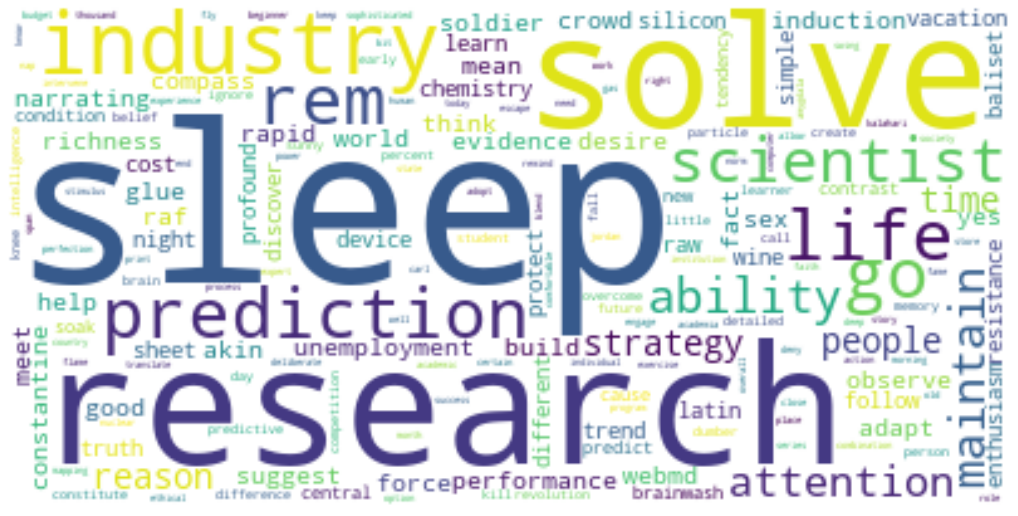

In [101]:
import random
sample = random.choices(sum(tokens, []), k=200)
# select top 200 rows from dataframe
# sample = tokens_count_df.head(200)['token'].tolist()
wordcloud = WordCloud(background_color="white").generate(' '.join(sample))

# display word cloud
fig = plt.figure(figsize=(18, 18))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
